# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import time
from datetime import datetime
from tqdm import tqdm
import joblib

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, ParameterGrid, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import StackingRegressor

import xgboost as xgb
import lightgbm as lgb

# Loading the datasets

In [3]:
df_train=pd.read_csv('dataset/train.csv')
df_test=pd.read_csv('dataset/test.csv')

In [4]:
dataset=[df_train.copy(),df_test.copy()]

# Unstructured Columns Transformation

## Description

In [5]:
for df in dataset:
  df['description_list']=df['description'].str.split(', ', regex=False)

In [6]:
def extract_structured_info(desc_list):
    total_rooms = None
    bedrooms = 0
    bathrooms = 0
    other_rooms = 0
    kitchen_type = 'none'
    accessible_bathroom = 0

    for item in desc_list:
        item = item.strip().lower()

        # Total rooms (standard or 5+ format)
        match_total = re.match(r'(\d+)\s*\(', item) or re.match(r'(\d+)\s+rooms?', item)
        match_total_plus = re.match(r'(\d+)\+\s*\(', item)

        if match_total:
            total_rooms = int(match_total.group(1))
        elif match_total_plus:
            total_rooms = int(match_total_plus.group(1))  # interpret "5+" as 5

        # Bedrooms (even inside parentheses)
        match_bed = re.search(r'(\d+)\s+bedrooms?', item)
        if match_bed:
            bedrooms += int(match_bed.group(1))

        # Bathrooms (standard + accessible)
        match_bath = re.match(r'(\d+)\s+bathrooms?', item)
        if match_bath:
            bathrooms += int(match_bath.group(1))
        elif "1 bathroom" in item:
            bathrooms += 1

        if "suitable for disabled" in item:
            accessible_bathroom = 1

        # Other rooms
        match_other = re.search(r'(\d+)\s+others?\)?', item)
        if match_other:
            other_rooms += int(match_other.group(1))
        elif "1 other" in item:
            other_rooms += 1

        # Kitchen type
        if "open kitchen" in item:
            kitchen_type = "open"
        elif "kitchen nook" in item:
            kitchen_type = "nook"
        elif "semi-habitable kitchen" in item:
            kitchen_type = "semi"
        elif "kitchenette" in item:
            kitchen_type = "ette"
        elif "kitchen diner" in item:
            kitchen_type = "diner"

    return pd.Series([total_rooms, bedrooms, other_rooms, bathrooms, kitchen_type, accessible_bathroom])

In [7]:
for df in dataset:
  df[['total_rooms', 'bedrooms', 'other_rooms', 'bathrooms', 'kitchen_type', 'accessible_bathroom']] = df['description_list'].apply(extract_structured_info)

Filling the number of total rooms if empty

In [8]:
for df in dataset:
  df['total_rooms'] = df['total_rooms'].fillna(
    df[['bedrooms', 'other_rooms', 'bathrooms']].sum(axis=1)
    )

## Others features

In [9]:
for df in dataset:
  df['other_features_list'] = df['other_features'].str.split(' | ', regex=False)

In [10]:
# Ensure all entries are lists (replace non-lists with empty list)
for df in dataset:
  df['other_features_list'] = df['other_features_list'].apply(
      lambda x: x if isinstance(x, list) else []
  )
  oth_features_set = {
      feat
      for feature_list in df['other_features_list']
      for feat in feature_list
  }

### Text transformation

In [11]:
for df in dataset:
  mlb = MultiLabelBinarizer()
  feature_dummies = pd.DataFrame(
      mlb.fit_transform(df['other_features_list']),
      columns=mlb.classes_,
      index=df.index
  )

In [12]:
macro_feature_map = {
    # 1. FURNISHING
    'furnished': 'furnishing',
    'partially furnished': 'furnishing',
    'only kitchen furnished': 'furnishing',
    'kitchen': 'furnishing',

    # 2. SECURITY
    'security door': 'security',
    'electric gate': 'security',
    'alarm system': 'security',
    'video entryphone': 'security',

    # 3. TV / INTERNET
    'centralized tv system': 'tv_internet',
    'single tv system': 'tv_internet',
    'tv system with satellite dish': 'tv_internet',
    'optic fiber': 'tv_internet',

    # 4. OUTDOOR SPACES
    'balcony': 'outdoor_space',
    '3 balconies': 'outdoor_space',
    'terrace': 'outdoor_space',
    'private garden': 'outdoor_space',
    'shared garden': 'outdoor_space',
    'private and shared garden': 'outdoor_space',

    # 5. CONCIERGE
    'full day concierge': 'concierge',
    'half-day concierge': 'concierge',
    'reception': 'concierge',
    'reception1 balcony': 'concierge',

    # 6. STORAGE / ROOMS
    'closet': 'storage',
    'cellar': 'storage',
    'attic': 'storage',
    'tavern': 'storage',

    # 7. WINDOWS
    'window frames in double glass / wood': 'windows',
    'window frames in double glass / pvc': 'windows',
    'window frames in glass / metal': 'windows',
    'window frames in double glass / pvcdouble exposure': 'windows',
    'window frames in double glass / metal': 'windows',
    'window frames in glass / wood': 'windows',
    'window frames in glass / pvc': 'windows',
    'window frames in triple glass / wood': 'windows',
    'window frames in triple glass / pvc': 'windows',
    'window frames in triple glass / metal': 'windows',
    'window frames in glass / pvcdouble exposure': 'windows',
    'window frames in triple glass / pvcdouble exposure': 'windows',
    'window frames in double glass / pvcexposure south': 'windows',
    'window frames in double glass / pvcexposure east': 'windows',
    'window frames in double glass / pvcexposure north': 'windows',
    'window frames in double glass / pvcexposure south, east': 'windows',
    'window frames in double glass / pvcexposure east, west': 'windows',
    'window frames in double glass / pvcexposure north, south': 'windows',
    'window frames in double glass / pvcexposure west': 'windows',
    'window frames in triple glass / pvcexposure south': 'windows',
    'window frames in double glass / pvcexposure south, west': 'windows',
    'window frames in glass / pvcexposure east': 'windows',
    'window frames in glass / pvcexposure west': 'windows',
    'window frames in double glass / pvcexposure north, west': 'windows',
    'window frames in double glass / pvcexposure south, east, west': 'windows',
    'window frames in glass / pvcexposure north, south': 'windows',
    'window frames in double glass / pvcexposure north, south, east': 'windows',
    'window frames in double glass / pvcexposure north, east, west': 'windows',
    'window frames in glass / pvcexposure south, east, west': 'windows',
    'window frames in glass / pvcexposure north, south, west': 'windows',
    'window frames in glass / pvcexposure north': 'windows',
    'window frames in glass / pvcexposure east, west': 'windows',
    'window frames in glass / pvcexposure south': 'windows',
    'window frames in triple glass / pvcexposure east, west': 'windows',
    'window frames in triple glass / pvcexposure south, east': 'windows',

    # 8. EXPOSURE
    'internal exposure': 'exposure',
    'external exposure': 'exposure',
    'double exposure': 'exposure',
    'exposure south': 'exposure',
    'exposure east': 'exposure',
    'exposure west': 'exposure',
    'exposure north': 'exposure',
    'exposure east, west': 'exposure',
    'exposure north, south': 'exposure',
    'exposure south, east': 'exposure',
    'exposure south, west': 'exposure',
    'exposure north, west': 'exposure',
    'exposure north, east': 'exposure',
    'exposure north, south, east, west': 'exposure',
    'exposure north, south, west': 'exposure',
    'exposure north, south, east': 'exposure',
    'exposure north, east, west': 'exposure',

    # 9. LUXURY / AMENITIES
    'fireplace': 'luxury',
    'hydromassage': 'luxury',
    'pool': 'luxury',
    'tennis court': 'luxury',
}

In [13]:
def aggregate_macro_features(feature_list, mapping):
    if not isinstance(feature_list, list):
        return []
    return list({mapping.get(f, None) for f in feature_list if mapping.get(f, '')})

for df in dataset:
  # Apply the macro feature mapping to your DataFrame
  df['macro_features'] = df['other_features_list'].apply(
      lambda feats: aggregate_macro_features(feats, macro_feature_map)
  )

### Top features of `other_features`

In [14]:
feature_groups = {
    'top_furnishing': {'closet', 'partially furnished'},
    'top_security': {'security door', 'video entryphone', 'alarm system'},
    'top_tv_system': {'centralized tv system'},
    'top_fiber': {'optic fiber'},
    'top_concierge': {'full day concierge', 'half-day concierge', 'reception'},
    'top_garden': {'shared garden', 'private garden'},
    'top_balcony': {'balcony', 'terrace'},
    'top_kitchen': {'kitchen', 'only kitchen furnished'},
    'luxury':{'fireplace','hydromassage','pool','tennis court'}
}

# Create dummy columns
for df in dataset:
  for col_name, keywords in feature_groups.items():
      df[col_name] = df['other_features_list'].apply(
          lambda features: int(any(item in features for item in keywords))
      )

### Transforming the `macro_features`

In [15]:
# List of macro_features to track
macro_features_list = ['furnishing', 'security', 'tv_internet', 'outdoor_space', 'concierge', 'storage', 'windows', 'exposure', 'luxury']

# Iterate over each feature in the list and create a new column in the DataFrame
for df in dataset:
  for feature in macro_features_list:
      df[feature] = df['macro_features'].apply(lambda x: x.count(feature) if isinstance(x, list) else 0)

# Structured Column Transformation 

In [16]:
for df in dataset:
  df['energy_efficiency_class'] = df['energy_efficiency_class'].replace(',', 'g')

## Zone's Mapping

In [17]:
zone_mapping = {
    # milano_centro
    'arco_della_pace': 'milano_centro',
    'arena': 'milano_centro',
    'brera': 'milano_centro',
    'borgogna_largo_augusto': 'milano_centro',
    'cadorna_castello': 'milano_centro',
    'carrobbio': 'milano_centro',
    'duomo': 'milano_centro',
    'guastalla': 'milano_centro',
    'lanza': 'milano_centro',
    'missori': 'milano_centro',
    'moscova': 'milano_centro',
    'navigli_darsena': 'milano_centro',
    'palestro': 'milano_centro',
    'paolo_sarpi': 'milano_centro',
    'quadrilatero_della_moda': 'milano_centro',
    'san_vittore': 'milano_centro',
    'san_babila': 'milano_centro',
    'scala_manzoni': 'milano_centro',
    'sempione': 'milano_centro',
    'vincenzo_monti': 'milano_centro',
    'quadronno_crocetta':'milano_centro',
    'turati': 'milano_centro',

    # milano_nord_est
    'buenos_aires': 'milano_nord_est',
    'bignami_ponale': 'milano_nord_est',
    'cascina_dei_pomi': 'milano_nord_est',
    'casoretto': 'milano_nord_est',
    'cimiano': 'milano_nord_est',
    'centrale': 'milano_nord_est',
    'città_studi': 'milano_nord_est',
    'crescenzago':'milano_nord_est',
    'dezza': 'milano_nord_est',
    'greco_segnano': 'milano_nord_est',
    'gorla': 'milano_nord_est',
    'istria': 'milano_nord_est',
    'indipendenza':'milano_nord_est',
    'lambrate': 'milano_nord_est',
    'maggiolina': 'milano_nord_est',
    'melchiorre_gioia': 'milano_nord_est',
    'morgagni': 'milano_nord_est',
    'ortica': 'milano_nord_est',
    'repubblica': 'milano_nord_est',
    'parco_trotter': 'milano_nord_est',
    'pasteur': 'milano_nord_est',
    'plebisciti_susa': 'milano_nord_est',
    'piave_tricolore': 'milano_nord_est',
    'porta_venezia':'milano_nord_est',
    'precotto': 'milano_nord_est',
    'ponte_nuovo':'milano_nord_est',
    'quartiere_adriano': 'milano_nord_est',
    'quartiere_feltre': 'milano_nord_est',
    'rovereto':  'milano_nord_est',
    'rubattino': 'milano_nord_est',
    'turro': 'milano_nord_est',
    'villa_san_giovanni': 'milano_nord_est',
    'zara': 'milano_nord_est',

    # milano_nord_ovest
    'affori': 'milano_nord_ovest',
    'bicocca': 'milano_nord_ovest',
    'bovisa': 'milano_nord_ovest',
    'bruzzano': 'milano_nord_ovest',
    'ca_granda': 'milano_nord_ovest',
    'cascina_merlata_musocco': 'milano_nord_ovest',
    'cenisio': 'milano_nord_ovest',
    'certosa': 'milano_nord_ovest',
    'city_life': 'milano_nord_ovest',
    'comasina': 'milano_nord_ovest',
    'dergano': 'milano_nord_ovest',
    'farini': 'milano_nord_ovest',
    'ghisolfa_mac_mahon': 'milano_nord_ovest',
    'gallaratese': 'milano_nord_ovest',
    'garibaldi_corso_como': 'milano_nord_ovest',
    'isola': 'milano_nord_ovest',
    'monte_rosa_lotto': 'milano_nord_ovest',
    'niguarda': 'milano_nord_ovest',
    'porta_nuova': 'milano_nord_ovest',
    'prato_centenaro': 'milano_nord_ovest',
    'qt8': 'milano_nord_ovest',
    'quarto_oggiaro': 'milano_nord_ovest',
    'trenno': 'milano_nord_ovest',
    'san_carlo':'milano_nord_ovest',
    'udine':'milano_nord_ovest',

    # milano_sud_est
    'argonne_corsica': 'milano_sud_est',
    'bologna_sulmona': 'milano_sud_est',
    'bocconi': 'milano_sud_ovest',
    'cadore': 'milano_sud_est',
    'cantalupa_san_paolo': 'milano_sud_est',
    'chiesa_rossa': 'milano_sud_est',
    'corvetto': 'milano_sud_est',
    'famagosta': 'milano_sud_est',
    'gratosoglio': 'milano_sud_est',
    'martini_insubria': 'milano_sud_est',
    'molise_cuoco': 'milano_sud_est',
    'montenero': 'milano_sud_est',
    'lodi_brenta': 'milano_sud_est',
    'pezzotti_meda': 'milano_sud_est',
    'ponte_lambro': 'milano_sud_est',
    'porta_romana_medaglie_doro': 'milano_sud_est',
    'porta_vittoria': 'milano_sud_est',
    'portello_parco_vittoria': 'milano_nord_ovest',
    'quartiere_forlanini': 'milano_sud_est',
    'ripamonti': 'milano_sud_est',
    'rogoredo': 'milano_sud_est',
    'santa_giulia': 'milano_sud_est',
    'vigentino_fatima': 'milano_sud_est',
    'viale_ungheria_mecenate': 'milano_sud_est',

    # milano_sud_ovest
    'amendola_buonarroti': 'milano_sud_ovest',
    'ascanio_sforza': 'milano_sud_ovest',
    'baggio': 'milano_sud_ovest',
    'bagno': 'milano_sud_ovest',
    'barona': 'milano_sud_ovest',
    'bande_nere': 'milano_sud_ovest',
    'bisceglie': 'milano_sud_ovest',
    'cermenate_abbiategrasso': 'milano_sud_ovest',
    'corso_genova': 'milano_sud_ovest',
    'corso_san_gottardo': 'milano_sud_ovest',
    'de_angeli': 'milano_sud_ovest',
    'frua': 'milano_sud_ovest',
    'giambellino': 'milano_sud_ovest',
    'gambara': 'milano_sud_ovest',
    'inganni': 'milano_sud_ovest',
    'lorenteggio': 'milano_sud_ovest',
    'pagano:': 'milano_sud_ovest',
    'piazza_napoli': 'milano_sud_ovest',
    'piazzale_siena': 'milano_sud_ovest',
    'primaticcio': 'milano_sud_ovest',
    'quarto_cagnino': 'milano_sud_ovest',
    'san_siro': 'milano_sud_ovest',
    'santambrogio':'milano_sud_ovest',
    'solari': 'milano_sud_ovest',
    'tre_castelli_faenza': 'milano_sud_ovest',
    'ticinese': 'milano_sud_ovest',
    'tripoli_soderini': 'milano_sud_ovest',
    'vercelli_wagner': 'milano_sud_ovest',
    'washington': 'milano_sud_ovest'
}


## Large Geo-coding

In [18]:
# df_geo = pd.DataFrame({
#     'zone_key': list(zone_mapping.keys()),
#     'macro_area': list(zone_mapping.values())
# })

# geolocator = Nominatim(user_agent="my_milan_geocoder")
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1, max_retries=2)

# def make_query(zone):
#     name = zone.replace("_", " ")
#     return f"{name}, Milano, Italy"

# latitudes = []
# longitudes = []
# for zone in df_geo['zone_key']:
#     loc = geocode(make_query(zone))
#     if loc:
#         latitudes.append(loc.latitude)
#         longitudes.append(loc.longitude)
#     else:
#         latitudes.append(None)
#         longitudes.append(None)

# df_geo['latitude']  = latitudes
# df_geo['longitude'] = longitudes

# # df.to_csv("milan_zones_geocoded.csv", index=True)

## Pre-process of zones

In [19]:
def preprocess_text(text):
    text = text.lower()
    text = text.replace(' - ', ' ')
    text = text.replace("'", "")

    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.replace(' ', '_')

    return text

## Preprocessing multiple columns

In [20]:
def preprocess_data(df_train, df_test):
    # Combine train and test temporarily for consistent processing
    df_all = pd.concat([df_train, df_test], keys=["train", "test"])

    # 1. Fill missing values
    df_all['availability'] = df_all['availability'].fillna('available')
    df_all['conditions'] = df_all['conditions'].fillna('excellent')
    df_all['condominium_fees'] = df_all['condominium_fees'].fillna(0.00)
    df_all['other_features'] = df_all['other_features'].fillna(' ')

    # Fill 'energy_efficiency_class' by mode within each zone
    zone_energy_mode = df_all.groupby('zone')['energy_efficiency_class'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    df_all['energy_efficiency_class'] = df_all.apply(
        lambda row: zone_energy_mode[row['zone']] if pd.isna(row['energy_efficiency_class']) else row['energy_efficiency_class'],
        axis=1
    )

    # Replace string "nan" in 'floor' with the most frequent floor
    most_freq_floor = df_all['floor'].replace("nan", pd.NA).mode()[0]
    df_all['floor'] = df_all['floor'].replace("nan", pd.NA).fillna(most_freq_floor)

    # 2. One-hot encode 'contract_type'
    df_all = pd.get_dummies(df_all, columns=['contract_type'], drop_first=True)

    # 3. Encode 'energy_efficiency_class' as ordered category
    energy_order = ['g', 'f', 'e', 'd', 'c', 'b', 'a']  # You may adjust this order
    df_all['energy_efficiency_class'] = pd.Categorical(
        df_all['energy_efficiency_class'], categories=energy_order, ordered=True
    ).codes

    df_all['zone']=df_all['zone'].apply(preprocess_text)
    df_all['macro_zone']=df_all['zone'].map(zone_mapping)
    df_all=pd.get_dummies(df_all,columns=['energy_efficiency_class'],drop_first=True)
    df_all=pd.get_dummies(df_all,columns=['macro_zone'],drop_first=True)

    # Separate back into train and test
    df_train_processed = df_all.loc["train"].copy()
    df_test_processed = df_all.loc["test"].copy()

    return df_train_processed, df_test_processed

## Computing the cleaned version

In [21]:
clean_train, clean_test=preprocess_data(dataset[0], dataset[1])
print(clean_train.shape,clean_test.shape)

(4500, 53) (2834, 53)


## Adding latitude and longitude

In [22]:
# coordinates=df_geo.copy()
coordinates=pd.read_excel('dataset/milan_zones_geocoded.xlsx')

In [23]:
clean_train['zone']=clean_train['zone'].replace('città_studi','citta_studi')
clean_test['zone']=clean_test['zone'].replace('città_studi','citta_studi')

In [24]:
clean_train = clean_train.merge(coordinates, right_on='zone_key', left_on='zone',how='left')
clean_test = clean_test.merge(coordinates, right_on='zone_key', left_on='zone', how='left')

In [25]:
clean_train.drop(columns=['zone_key'], inplace=True)
clean_test.drop(columns=['zone_key'], inplace=True)

## Transforming floor, elevator, and condominium fee dummy

In [26]:
floor_map = {
    'Semi-basement': -1,
    'Mezzanine': 0.5,
    'Ground floor': 0,
    '1': 1, '2': 2, '3': 3, '4': 4,
    '5': 5, '6': 6, '7': 7, '8': 8, '9': 9
}

clean_train['floor'] = clean_train['floor'].map(floor_map).astype(float)
clean_train['elevator']= clean_train['elevator'].map({'yes':1,'no':0})
clean_train['high_floor_no_elevator'] = ((clean_train['floor'] >= 3) & (clean_train['elevator'] == 0)).astype(int)

clean_test['floor'] = clean_test['floor'].map(floor_map).astype(float)
clean_test['elevator']= clean_test['elevator'].map({'yes':1,'no':0})
clean_test['high_floor_no_elevator'] = ((clean_test['floor'] >= 3) & (clean_test['elevator'] == 0)).astype(int)

In [27]:
clean_train['have_condo_fees']=np.where(clean_train['condominium_fees']>0,1,0)
clean_test['have_condo_fees']=np.where(clean_test['condominium_fees']>0,1,0)

# Filtering Columns

In [28]:
columns_to_keep=['y', 'square_meters', 'floor', 'elevator', 'high_floor_no_elevator',
                           'conditions','have_condo_fees',
                           'total_rooms', 'bedrooms', 'other_rooms','bathrooms', 'kitchen_type', 'accessible_bathroom',
                           'top_furnishing', 'top_security', 'top_tv_system', 'top_fiber', 'top_concierge',
                           'top_garden', 'top_balcony', 'top_kitchen', 'luxury', 'furnishing', 'security',
                           'tv_internet', 'outdoor_space', 'concierge', 'storage', 'windows', 'exposure',
                           'energy_efficiency_class_1', 'energy_efficiency_class_2', 'energy_efficiency_class_3',
                           'energy_efficiency_class_4', 'energy_efficiency_class_5', 'energy_efficiency_class_6',
                           'condominium_fees', 'zone', 'contract_type_rent | 3+2', 'contract_type_rent | 4+4',
                           'contract_type_rent | 6+6', 'contract_type_rent | open',
                           'contract_type_rent | students (6 - 36 months)', 'contract_type_rent | transitory',
                           'macro_zone_milano_nord_est', 'macro_zone_milano_nord_ovest',
                           'macro_zone_milano_sud_est', 'macro_zone_milano_sud_ovest','macro_area', 'latitude','longitude']
filtered_df=clean_train[columns_to_keep]
filtered_test=clean_test[columns_to_keep]

In [29]:
fil_dataset=[filtered_df.copy(),filtered_test.copy()]

## Encoding of zones

In [30]:
zone_mean_price = filtered_df.groupby('zone')['y'].mean()

for df in fil_dataset:
  df.loc[:,'zone_encoded'] = df['zone'].map(zone_mean_price)

In [31]:
for df in fil_dataset:
  kitchen_dummies = pd.get_dummies(df['kitchen_type'], prefix='kitchen')
  df = pd.concat([df, kitchen_dummies], axis=1)

In [32]:
conditions_map = {
    'good condition': 1,
    'excellent': 2,
    'new': 3
}
for df in fil_dataset:
  df['conditions_encoded'] = df['conditions'].map(conditions_map)

In [33]:
filtered_df=fil_dataset[0].copy()
filtered_test=fil_dataset[1].copy()

In [34]:
filtered_df.drop(columns=['kitchen_type'], inplace=True)
filtered_test.drop(columns=['kitchen_type'], inplace=True)

filtered_df.drop(columns=['zone'], inplace=True)
filtered_test.drop(columns=['zone'], inplace=True)

filtered_df.drop(columns=['conditions'], inplace=True)
filtered_test.drop(columns=['conditions'], inplace=True)

filtered_df.drop(columns=['macro_area'], inplace=True)
filtered_test.drop(columns=['macro_area'], inplace=True)

## logarithmic Transformation

In [35]:
filtered_df.loc[:,'y'] = np.log1p(filtered_df['y'])

In [36]:
filtered_df.loc[:, 'condominium_fees'] = np.log1p(filtered_df['condominium_fees'])
filtered_test.loc[:, 'condominium_fees'] = np.log1p(filtered_test['condominium_fees'])

In [37]:
filtered_df.to_csv('dataset/filtered_df.csv')
filtered_test.to_csv('dataset/filtered_test.csv')

# Model

In [38]:
filtered_test.drop(columns=['y'],inplace=True)

In [39]:
X_train = filtered_df.drop(columns=['y']).copy()
y_train = filtered_df['y'].copy()

In [40]:
X_train.columns = X_train.columns.str.replace(' ', '_')
filtered_test.columns = filtered_test.columns.str.replace(' ', '_')

## Model estimation

In [41]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
    enable_categorical=False,
    n_jobs=-1,
    # --- tuning parameters
    n_estimators=4600,
    learning_rate=0.0085,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,
    reg_lambda=0.0
)

lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    # --- tuning parameters
    n_estimators=4600,
    learning_rate=0.008,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.01
)

In [42]:
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

joblib.dump(xgb_model, "FINAL_xgb_final.joblib")
joblib.dump(lgb_model, "FINAL_lgb_final.joblib")

['FINAL_lgb_final.joblib']

## Stack

### Meta-Learner

In [43]:
meta_learner = ElasticNetCV(
    l1_ratio=[.005],
    alphas=[.0004641588833612782],
    cv=10,
    random_state=42
)

In [44]:
stack = StackingRegressor(
    estimators=[
        ('xgb',  xgb_model),
        ('lgb',  lgb_model)
    ],
    final_estimator=meta_learner,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1,
    passthrough=False
)

In [45]:
stack.fit(X_train, y_train)
y_pred_test = stack.predict(filtered_test)

y_pred_test_normal = np.expm1(y_pred_test)

In [46]:
fitted_meta_learner = stack.final_estimator_

print(f"Chosen alpha: {fitted_meta_learner.alpha_}")
print(f"Chosen l1_ratio: {fitted_meta_learner.l1_ratio_}")

Chosen alpha: 0.0004641588833612782
Chosen l1_ratio: 0.005


# Saving results

In [47]:
today_str = str(datetime.now().isoformat(timespec='seconds').replace(':', '-'))

with open(f'RESULTS/FINAL_predicted_rent_prices_{today_str}.txt', 'w') as f:
    for value in y_pred_test_normal:
        f.write(f"{value}\n")

In [48]:
joblib.dump(stack, f'MODELS/{today_str}_FINAL_stacking_model.pkl')

['MODELS/2025-05-21T14-56-21_FINAL_stacking_model.pkl']

## Stack Graphs

In [57]:
# Fit stack on full data
stack.fit(X_train, y_train)

# meta_learner is an ElasticNet; get coefficients
coefs = stack.final_estimator_.coef_
intercept = stack.final_estimator_.intercept_

print(f"ElasticNet blend:   ŷ = {coefs[0]:.3f}·XGB  +  {coefs[1]:.3f}·LGB  +  {intercept:.3f}")

ElasticNet blend:   ŷ = 0.600·XGB  +  0.389·LGB  +  0.079


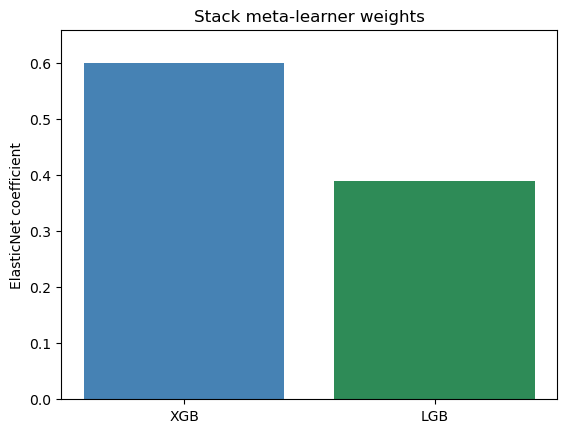

In [58]:
plt.bar(["XGB", "LGB"], coefs, color=["steelblue", "seagreen"])
plt.ylabel("ElasticNet coefficient")
plt.title("Stack meta-learner weights")
plt.ylim(0, max(coefs)*1.1)
plt.show()

In [59]:
# from sklearn.inspection import permutation_importance

# stack.fit(X_train, y_train)

# r = permutation_importance(
#         stack, X_train, y_train,
#         n_repeats=10, scoring="neg_mean_absolute_error",
#         random_state=42, n_jobs=-1)

# imp_df = (pd.DataFrame({"feature": X_train.columns,
#                         "importance": r.importances_mean})
#             .sort_values("importance", ascending=False))

# plt.barh(imp_df.feature[:25][::-1], imp_df.importance[:25][::-1])
# plt.xlabel("↓ MAE when permuted")
# plt.title("Permutation importance – full stack")
# plt.tight_layout(); plt.show()
